In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from virtual_frontal import make_virtual_frontal_from_temporals, lowpass_delta_frontal


In [2]:
DATA_DIR = Path('/Users/wolfgang/cdac Dropbox/a_People_BIDMC/WolfgangGanglberger/Muse/data_david/slow_waves_2025_09')
if not DATA_DIR.exists():
    raise FileNotFoundError(f"Data directory not found: {DATA_DIR}")

# Select the first available Muse EEG recording
EEG_FILE = sorted(DATA_DIR.glob('*_eeg.csv'))[0]
print(f'Using EEG recording: {EEG_FILE.name}')
STAGE_FILE = EEG_FILE.with_name(EEG_FILE.name.replace('_eeg.csv', '_ss.csv'))
fs = 256

df_eeg = pd.read_csv(EEG_FILE)
print(f'Columns in EEG data: {df_eeg.columns.tolist()}')
df_stage = pd.read_csv(STAGE_FILE)
print(f'Columns in Stage data: {df_stage.columns.tolist()}')

# Merge the two dataframes based on the closest timestamps
df_stage['eeg_ts'] = df_stage['timestamps'].apply(lambda x: df_eeg.ts.iloc[(df_eeg.ts - x).abs().idxmin()])
stage_cols = [x for x in df_stage.columns if x not in ['timestamps', 'eeg_ts', 'times']]
df_eeg = pd.merge(df_eeg, df_stage[['eeg_ts'] + stage_cols], left_on='ts', right_on='eeg_ts', how='left')
df_eeg = df_eeg.drop(['eeg_ts'], axis=1)
for col in stage_cols: # Fill missing stage data by forward filling, limit to 30 seconds
    df_eeg[col] = df_eeg[col].fillna(method='ffill', limit=fs*30)

# Make virtual frontal channel from temporals (mimics Fpz to M1/M2 in PSG setups)
v_frontal, v1, v2, mask_good = make_virtual_frontal_from_temporals(
    df_eeg, fs=fs, return_details=True
)
v_frontal_delta = lowpass_delta_frontal(v_frontal, fs=fs)


Using EEG recording: 2022-03-21T01-03-21+04-00_6002-7AD9-67DA_eeg.csv
Columns in EEG data: ['ts', 'ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6']
Columns in Stage data: ['times', 'sleep_stage', 'noise_level_channel_1', 'noise_level_channel_2', 'noise_level_channel_3', 'noise_level_channel_4', 'timestamps']


/var/folders/94/64zz174d6850j2k64xhtwyph0000gq/T/ipykernel_26516/1841840759.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_eeg[col] = df_eeg[col].fillna(method='ffill', limit=fs*30)


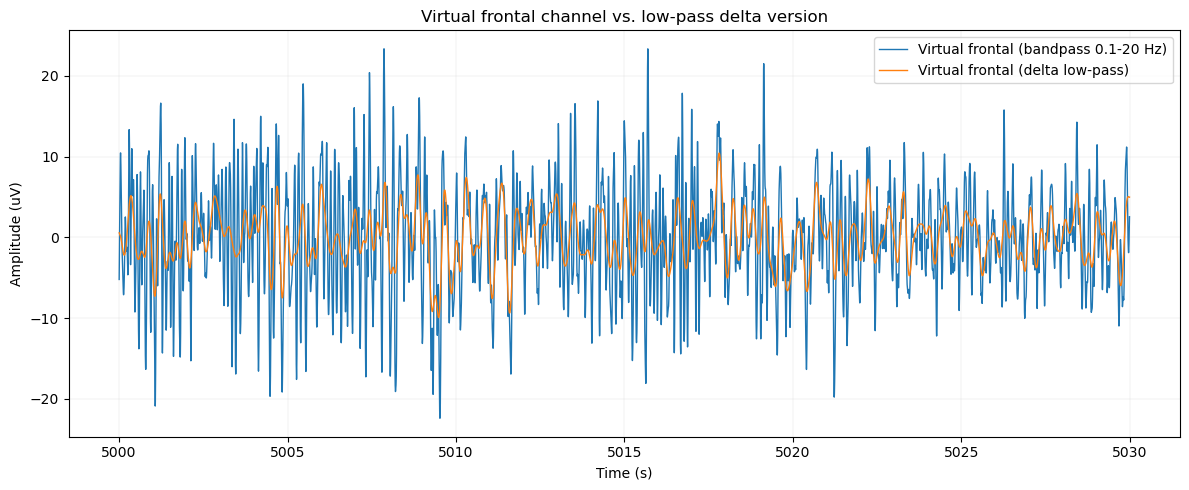

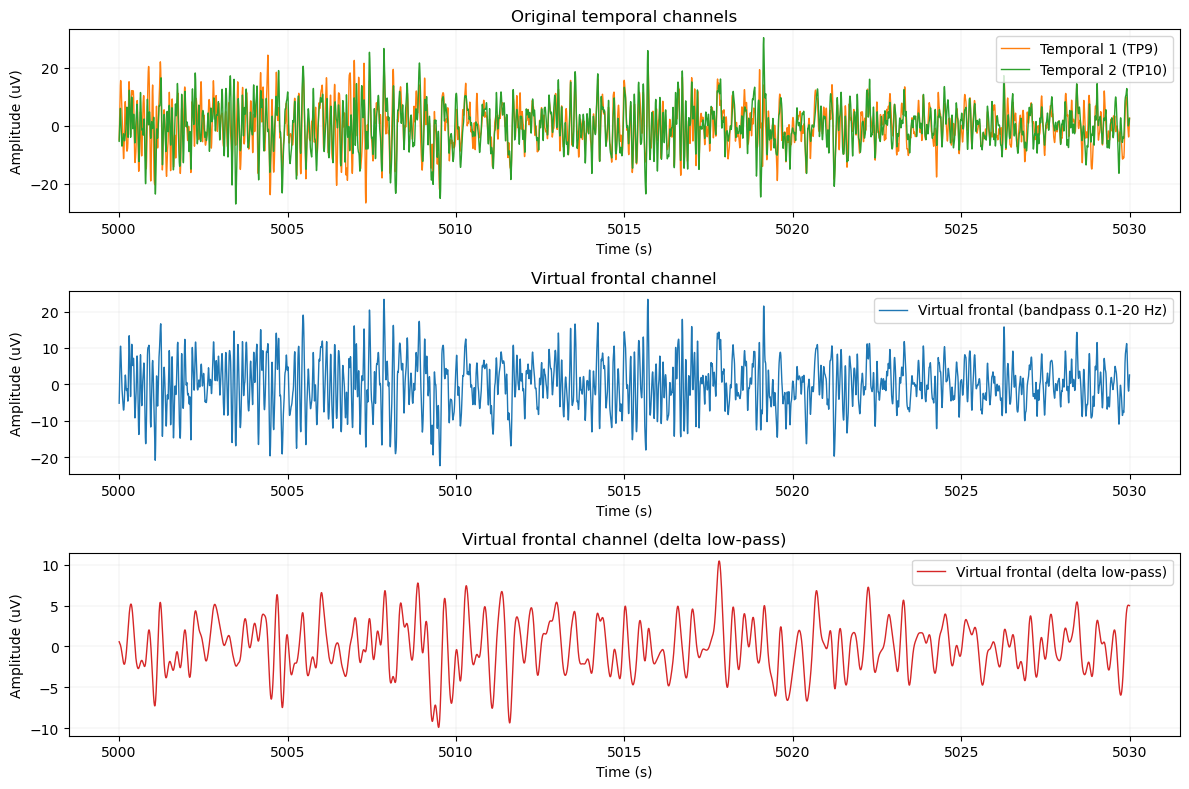

In [3]:
start_sec = 5000
duration_sec = 30
start_idx = int(start_sec * fs)
end_idx = int((start_sec + duration_sec) * fs)

time = np.arange(start_idx, end_idx) / fs
segment = slice(start_idx, end_idx)

plt.figure(figsize=(12, 5))
plt.plot(time, v_frontal[segment], label='Virtual frontal (bandpass 0.1-20 Hz)', linewidth=1.0)
plt.plot(time, v_frontal_delta[segment], label='Virtual frontal (delta low-pass)', linewidth=1.0)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.title('Virtual frontal channel vs. low-pass delta version')
plt.legend()
plt.grid(True, linewidth=0.3, alpha=0.4)
plt.tight_layout()

# Another plot with subplots with original EEG channels:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(time, v1[segment], label='Temporal 1 (TP9)', color='C1', linewidth=1.0)
plt.plot(time, v2[segment], label='Temporal 2 (TP10)', color='C2', linewidth=1.0)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.title('Original temporal channels')
plt.legend()
plt.grid(True, linewidth=0.3, alpha=0.4)
plt.subplot(3, 1, 2)
plt.plot(time, v_frontal[segment], label='Virtual frontal (bandpass 0.1-20 Hz)', color='C0', linewidth=1.0)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.title('Virtual frontal channel')
plt.legend()
plt.grid(True, linewidth=0.3, alpha=0.4)
plt.subplot(3, 1, 3)
plt.plot(time, v_frontal_delta[segment], label='Virtual frontal (delta low-pass)', color='C3', linewidth=1.0)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.title('Virtual frontal channel (delta low-pass)')
plt.legend()
plt.grid(True, linewidth=0.3, alpha=0.4)
plt.tight_layout()
plt.show()
